[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/simple_detector_v2.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

In [16]:
#import os
#import json
#import numpy as np 
#import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
#from pycocotools.coco import COCO
#import fiftyone as fo
#import time
#import torch
#import torchvision
#from torch.utils.data import Dataset, DataLoader
#import torchvision.transforms as transforms
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN
#import cv2

## Обучение модели

In [4]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone
if colab == True:
    dataset_path = '.'
else:
    dataset_path = 'data'

In [21]:
import os
import json
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
import fiftyone as fo

In [5]:
# Преобразование классов знаков в 1 класс
def anno_to_bin_class(anno_file):
    '''Функция создает копию файла с аннотацией, преобразует все классы в 1 (знак)
    и сохраняет новый файл с аннотацией'''
    with open(os.path.join(dataset_path, anno_file), 'r') as read_file:
        anno_json = json.load(read_file)
    read_file.close()

    for i in range(len(anno_json['annotations'])):
        anno_json['annotations'][i]['category_id'] = 1    
    
    anno_json['categories'] = [{'id': 1, 'name': 'sign'}]
    
    anno_file_new = anno_file.split('.')[0] + '_bin_class.json'
    
    with open(os.path.join(dataset_path, anno_file_new), 'w') as f:
        json.dump(anno_json, f)#ensure_ascii=False, indent=4)
    f.close()

    return anno_json
anno_to_bin_class('train_anno.json')
anno_to_bin_class('train_anno_reduced.json')
anno_to_bin_class('val_anno.json')

{'images': [{'id': 22978,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave10_10_2012_13_50_36_1.jpg'},
  {'id': 53820,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave24_10_2012_10_20_51_2.jpg'},
  {'id': 52206,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave23_10_2012_14_41_26_0.jpg'},
  {'id': 48186,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave23_10_2012_10_16_35_2.jpg'},
  {'id': 41953,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave16_10_2012_11_44_25_2.jpg'},
  {'id': 38421,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave16_10_2012_08_45_17_4.jpg'},
  {'id': 27187,
   'width': 1920,
   'height': 1080,
   'file_name': 'rtsd-frames/autosave13_04_2013_13_38_32_1.jpg'},
  {'id': 19104,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave10_10_2012_10_00_59_0.jpg'},
  {'id': 58486,
   'width': 1280,
   'height'

In [6]:
with open(os.path.join(dataset_path, 'train_anno_bin_class.json'), 'r') as read_file:
    temp = json.load(read_file)
read_file.close()
len(temp.get('images'))

54188

In [7]:
train_anno_coco = COCO(os.path.join(dataset_path, 'train_anno_bin_class.json'))

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


In [8]:
# получение идентификатора категории
train_anno_coco.getCatIds(['sign'])

[1]

In [9]:
# получение ID аннотации для указанного ID изображения
annotation_ids = train_anno_coco.getAnnIds(imgIds=95)
annotation_ids

[175, 176, 177]

In [10]:
# получение ID изображений, содержащих объект с указанным ID
len(train_anno_coco.getImgIds(catIds=[1]))

54188

In [11]:
# получение ID аннотации для указанных ID изображения и ID категории
annotation_ids = train_anno_coco.getAnnIds(imgIds=95, catIds=[1])
annotation_ids

[175, 176, 177]

In [17]:
def pycocotools_visualizer(image_id, category_id = None):
    '''функция по выводу изображения с указанным ID
    и визуализацией аннотаций с выбранными ID категорий (список)
    Если ID категорий не указаны - выводятся все аннотации для изображения'''
    if category_id:
        annotation_ids = train_anno_coco.getAnnIds(imgIds=image_id, catIds=category_id)
    else:
        annotation_ids = train_anno_coco.getAnnIds(imgIds=image_id)
            
    # загрузка аннотаций в список
    anns = train_anno_coco.loadAnns(annotation_ids)

    # путь к изображению и его название
    images_path = dataset_path
    image_name = train_anno_coco.imgs.get(image_id).get('file_name')
    image = Image.open(os.path.join(images_path, image_name))
    
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 10)
    
    # Draw boxes and add label to each box
    for ann in anns:
        box = ann['bbox']
        bb = patches.Rectangle((box[0],box[1]), box[2],box[3], linewidth=1, edgecolor="yellow", facecolor="none")
        ax.add_patch(bb)
    
    ax.imshow(image)
    plt.show()

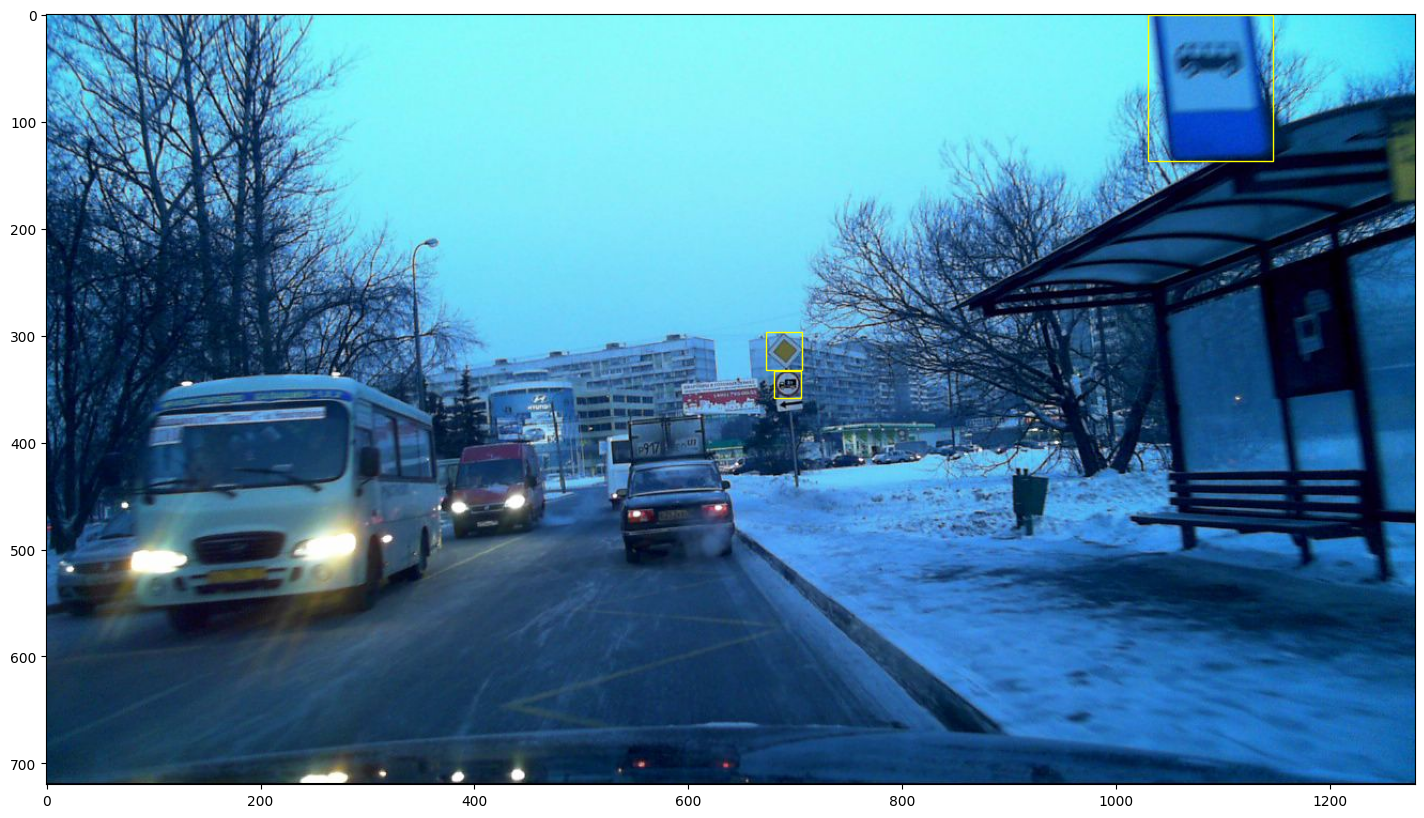

In [18]:
pycocotools_visualizer(95, [1])

In [22]:
# загрузка датасета

# The directiry containing the source images
data_path = dataset_path      # можно не указывать, если в JSON путь совпадает

# The path yo the COCO labels JSON file
labels_file = "train_anno_bin_class.json"
labels_path = os.path.join(dataset_path, labels_file)


# Import the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path
)

 100% |█████████████| 54188/54188 [1.5m elapsed, 0s remaining, 646.6 samples/s]      


In [23]:
# Визуализация набора данных
session = fo.launch_app(dataset)

In [24]:
# Использование агрегатов с помощью API для получения статистики о наборе данных
# Количество обнаружений для каждой категории
dataset.count_values("detections.detections.label")

{'sign': 95492}

In [25]:

class RTSD_dataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        super().__init__()
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [26]:
# In my case, just added ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [30]:
# path to your own data and coco file
train_data_dir = 'data'
train_coco = 'data/train_anno_reduced_bin_class.json'

# create own Dataset
my_dataset = RTSD_dataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 16

# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          #num_workers=1,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [28]:
# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps')

# DataLoader is iterable over Dataset
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)

[{'boxes': tensor([[1523.,  382., 1595.,  419.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([27329], device='cuda:0'), 'area': tensor([2664.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]
[{'boxes': tensor([[884., 307., 902., 334.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([7079], device='cuda:0'), 'area': tensor([486.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]
[{'boxes': tensor([[822., 283., 842., 301.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([40704], device='cuda:0'), 'area': tensor([360.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]
[{'boxes': tensor([[1055.,  229., 1124.,  262.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([55350], device='cuda:0'), 'area': tensor([2277.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]
[{'boxes': tensor([[1193.,  285., 1220.,  336.]], device='c

In [31]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model
    

# 2 classes; Only target class or background
num_classes = 2
num_epochs = 10
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

Iteration: 1/119, Loss: 1.3584920167922974
Iteration: 2/119, Loss: 1.262677550315857
Iteration: 3/119, Loss: 1.077278971672058
Iteration: 4/119, Loss: 0.9363219738006592
Iteration: 5/119, Loss: 0.8848811984062195
Iteration: 6/119, Loss: 0.8287410140037537
Iteration: 7/119, Loss: 0.7034909725189209
Iteration: 8/119, Loss: 0.5693236589431763
Iteration: 9/119, Loss: 0.44887375831604004
Iteration: 10/119, Loss: 0.3598034083843231
Iteration: 11/119, Loss: 0.32648056745529175
Iteration: 12/119, Loss: 0.4057238698005676
Iteration: 13/119, Loss: 0.3112877905368805
Iteration: 14/119, Loss: 0.23968341946601868
Iteration: 15/119, Loss: 0.2102968394756317
Iteration: 16/119, Loss: 0.17241661250591278
Iteration: 17/119, Loss: 0.2115144580602646
Iteration: 18/119, Loss: 0.1794457882642746
Iteration: 19/119, Loss: 0.17617399990558624
Iteration: 20/119, Loss: 0.1495427042245865
Iteration: 21/119, Loss: 0.14374244213104248
Iteration: 22/119, Loss: 0.20924752950668335
Iteration: 23/119, Loss: 0.212786719

In [8]:

# data loader
batch_size = 1
num_workers = 4

data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers
                                         )


import numpy as np
import matplotlib.pyplot as plt

for images, labels in data_loader:
    # image shape is [batch_size, 3 (due to RGB), height, width]
    img = transforms.ToPILImage()(images[0])
    plt.imshow(img)
    plt.show()
    print(labels)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/ds_env/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/envs/ds_env/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'RTSD_dataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 